In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
import warnings
warnings.filterwarnings('ignore')

In [9]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///C:\\Users\\kayvb\\OneDrive\\Desktop\\github Repos\\sqlalchemy-challenge\\Resources\\hawaii.sqlite")

In [10]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [11]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [12]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
inspector=inspect(engine)
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"{most_recent_date}")   

2017-08-23


Text(0.5, 0, 'Date')

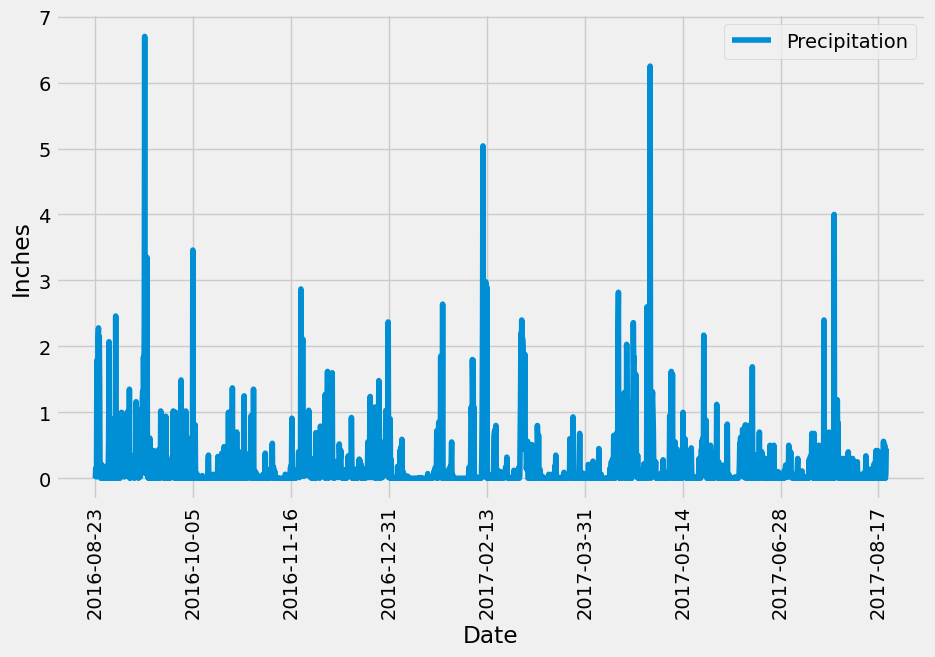

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
# Calculate the date one year from the last date in data set.
last_year = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])


# Sort the dataframe by date
precipitation_df.set_index('Date', inplace=True)
precipitation_df.dropna(inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation_df.plot(figsize=(10, 6))
plt.xticks(rotation=90)
plt.ylabel("Inches")
plt.xlabel("Date") 

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
query = "SELECT COUNT(DISTINCT station) AS total_stations FROM measurement;"
total_stations = engine.execute(query).fetchone()
print(f"[{total_stations}]")

[(9,)]


In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
results = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

## Answer the following question: which station id has the greatest number of observations?
- This information gives us an overview of the distribution of observations among different weather stations, where 'USC00519281' has the highest number of observations with 2772.

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = results[0][0]
temperature_data = [
    func.min(Measurement.tobs).label('min_temp'),                    
    func.max(Measurement.tobs).label('max_temp'), 
    func.avg(Measurement.tobs).label('avg_temp')
]
station_temperature_data = session.query(*temperature_data).\
    filter(Measurement.station == most_active_station_id).all()
for row in station_temperature_data:
    print(f" [({row.min_temp}, {row.max_temp}, {row.avg_temp})]")

 [(54.0, 85.0, 71.66378066378067)]


Text(0.5, 0, 'Temperature')

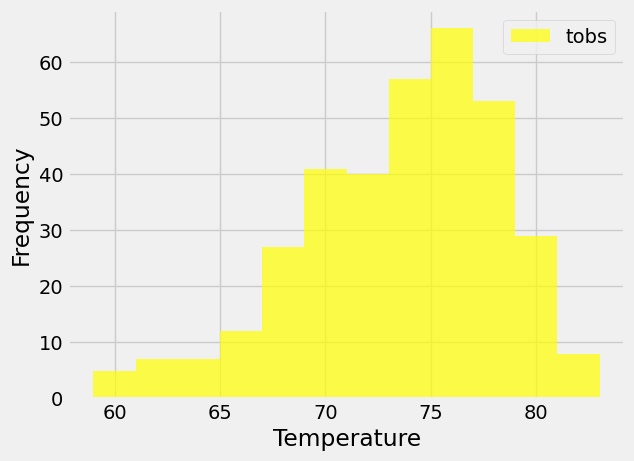

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= last_year).\
    filter(Measurement.station == most_active_station_id).all()
temp_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])
plt.hist(temp_df['Temperature'], bins=12, color='yellow',alpha=0.7, label='tobs')
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Temperature')

# Close Session

In [21]:
# Close Session
session.close()